## Choose model

In [3]:
model_name = 'distilbert-base-cased'

## Load dataset

In [5]:
from datasets import load_dataset, DatasetDict

In [6]:
dataset = load_dataset("jonathanli/law-stack-exchange")

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'LastActivityDate', 'AnswerCount', 'CommentCount', 'ContentLicense', 'body', 'text_label', 'title'],
        num_rows: 638
    })
    validation: Dataset({
        features: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'LastActivityDate', 'AnswerCount', 'CommentCount', 'ContentLicense', 'body', 'text_label', 'title'],
        num_rows: 319
    })
    test: Dataset({
        features: ['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'LastActivityDate', 'AnswerCount', 'CommentCount', 'ContentLicense', 'body', 'text_label', 'title'],
        num_rows: 1596
    })
})

In [8]:
dataset['train'][0]

{'Id': 71340,
 'PostTypeId': 1,
 'CreationDate': '2021-09-01T02:39:58.830',
 'Score': 0,
 'ViewCount': 128.0,
 'LastActivityDate': '2021-09-01T06:43:55.503',
 'AnswerCount': 1.0,
 'CommentCount': 9,
 'ContentLicense': 'CC BY-SA 4.0',
 'body': "I'm trying to comfortably use my laptop at night and now could not find an answer by web-search to the following: Why TVs / laptops etc. do not warn about too bright screen whereas many smartphones warn about too loud sound amplification? I'm asking on law site cause I suspect there were a number of successful lawsuits for impaired hearing from headphones but none for impaired vision from TVs. Am I right here? Digging down - has it happened because there are studies proving impairment for one and none for the other?\n\n\nAdded: I actually doubt my second guess cause there are a lot of enhancements in screen brightness - auto-brightness, night mode.\n\n\n",
 'text_label': 'civil-law',
 'title': 'Why TVs / laptops etc. do not warn about too brirght

## Prepare data

In [10]:
dataset = dataset.remove_columns(["Id", "PostTypeId", "CreationDate", "Score", "ViewCount", "LastActivityDate",
                                 "AnswerCount", "CommentCount", "ContentLicense", "title"])

In [11]:
dataset = dataset.rename_column("text_label", "label")
dataset = dataset.rename_column("body", "text")

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 638
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 319
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1596
    })
})

In [13]:
import pandas as pd

<Axes: ylabel='0'>

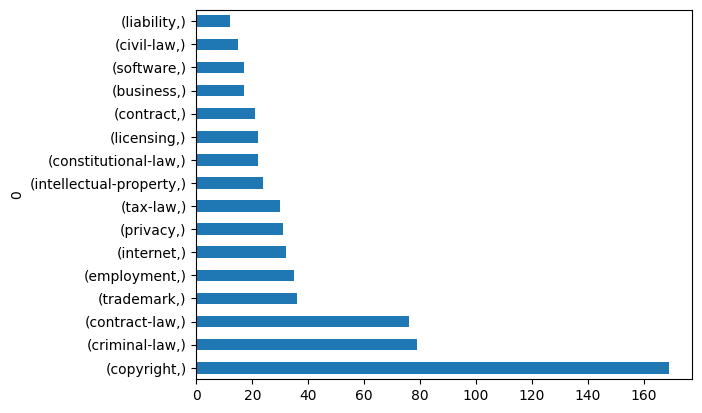

In [14]:
train_labels = pd.DataFrame(dataset['train']['label']).value_counts()
train_labels.plot(kind='barh')

<Axes: ylabel='0'>

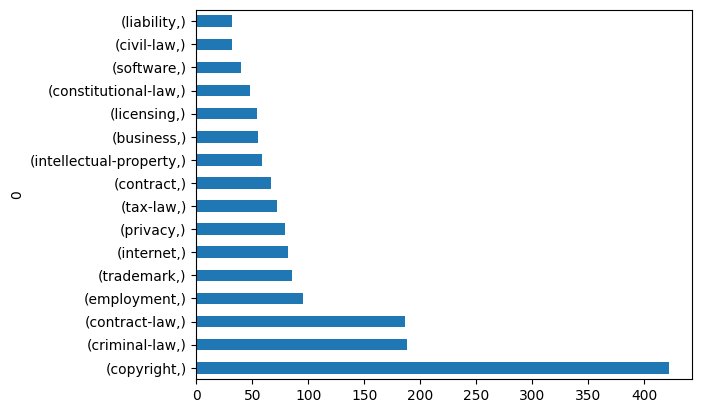

In [15]:
test_labels = pd.DataFrame(dataset['test']['label']).value_counts()
test_labels.plot(kind='barh')

In [16]:
# balance the dataset and take just 4 classes
from datasets import concatenate_datasets

NUM_TRAINING_SAMPLES = 30
NUM_TESTING_SAMPLES = 7

# criminal-law 
label_6_train_data = dataset['train'].filter(lambda example: example["label"] == 'criminal-law').select(range(NUM_TRAINING_SAMPLES))
label_6_test_data = dataset['test'].filter(lambda example: example["label"] == 'criminal-law').select(range(NUM_TESTING_SAMPLES))
# employment (7)
label_7_train_data = dataset['train'].filter(lambda example: example["label"] == 'employment').select(range(NUM_TRAINING_SAMPLES))
label_7_test_data = dataset['test'].filter(lambda example: example["label"] == 'employment').select(range(NUM_TESTING_SAMPLES))
# tax-law (14)
label_14_train_data = dataset['train'].filter(lambda example: example["label"] == 'tax-law').select(range(NUM_TRAINING_SAMPLES))
label_14_test_data = dataset['test'].filter(lambda example: example["label"] == 'tax-law').select(range(NUM_TESTING_SAMPLES))
# trademark (15)
label_15_train_data = dataset['train'].filter(lambda example: example["label"] == 'trademark').select(range(NUM_TRAINING_SAMPLES))
label_15_test_data = dataset['test'].filter(lambda example: example["label"] == 'trademark').select(range(NUM_TESTING_SAMPLES))

In [17]:
train_data = concatenate_datasets([label_6_train_data, label_7_train_data, label_14_train_data, label_15_train_data])
train_data

Dataset({
    features: ['text', 'label'],
    num_rows: 120
})

In [18]:
test_data = concatenate_datasets([label_6_test_data, label_7_test_data, label_14_test_data, label_15_test_data])
test_data

Dataset({
    features: ['text', 'label'],
    num_rows: 28
})

In [19]:
NUM_LABELS = 4

In [20]:
# need to properly encode the labels 
from datasets import Dataset, Value, ClassLabel, Features

In [21]:
dataset['train'].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='string', id=None)}

In [22]:
features = Features({"text": Value("string"), "label": ClassLabel(num_classes=NUM_LABELS, names=list(set(train_data['label'])))})

In [23]:
def encode_labels(dataset):
    encoded_data = pd.DataFrame(dataset)
    encoded_data = Dataset.from_pandas(encoded_data)
    encoded_data = encoded_data.class_encode_column("label")
    return encoded_data

In [24]:
train_data = encode_labels(train_data)
test_data = encode_labels(test_data)

Casting to class labels:   0%|          | 0/120 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/28 [00:00<?, ? examples/s]

In [25]:
train_data.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['criminal-law', 'employment', 'tax-law', 'trademark'], id=None)}

In [26]:
# create id2label and label2id
labels = train_data.features['label'].names
ids = range(NUM_LABELS)
id2label = dict(zip(ids, labels))   
label2id = dict(zip(labels, ids)) 

In [27]:
# tokenize
from transformers import AutoTokenizer

In [28]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [29]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [30]:
tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_test = test_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/28 [00:00<?, ? examples/s]

In [31]:
tokenized_train = tokenized_train.remove_columns(["text"])
tokenized_test = tokenized_test.remove_columns(["text"])

## Train model

In [33]:
from transformers import AutoModelForSequenceClassification

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, label2id=label2id, id2label=id2label)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
from transformers import TrainingArguments

In [36]:
training_args = TrainingArguments(output_dir="my_test_model", eval_strategy="epoch")

In [37]:
import numpy as np
import evaluate

In [38]:
metric = evaluate.load("accuracy")

In [39]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [40]:
from transformers import Trainer

In [41]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

In [42]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.125692,0.750000
2,No log,0.635660,0.928571
3,No log,0.466047,0.964286


TrainOutput(global_step=45, training_loss=0.891310797797309, metrics={'train_runtime': 470.6212, 'train_samples_per_second': 0.765, 'train_steps_per_second': 0.096, 'total_flos': 47689964421120.0, 'train_loss': 0.891310797797309, 'epoch': 3.0})

## Evaluate model

In [44]:
trainer.evaluate()

{'eval_loss': 0.4660474359989166,
 'eval_accuracy': 0.9642857142857143,
 'eval_runtime': 9.7667,
 'eval_samples_per_second': 2.867,
 'eval_steps_per_second': 0.41,
 'epoch': 3.0}

## Hyperparameter tuning

In [46]:
import optuna

In [47]:
# initialise a new model for each tuning run
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS, label2id=label2id, id2label=id2label)

In [48]:
# function to control the search of hyperparams to tune
def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "num_train_epochs": trial.suggest_categorical("num_train_epochs", [2, 3, 5])
    }

In [49]:
# create the training args for each tuning run
tuning_training_args = TrainingArguments(
    output_dir="model_tuning_output",
    eval_strategy="epoch",
    learning_rate=0.1,  # Placeholder; will be overridden by the hyperparameter search
    per_device_train_batch_size=16,  # Placeholder; will be overridden by the hyperparameter search
    num_train_epochs=3,  # Placeholder; will be overridden by the hyperparameter search
    logging_dir="./logs",
    #push_to_hub=True
)

In [50]:
#from huggingface_hub import notebook_login
#notebook_login()

In [51]:
tuning_trainer = Trainer(
    model_init=model_init,
    args=tuning_training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    processing_class=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
best_trial = tuning_trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=hp_space,
    n_trials=5
)

[I 2025-02-01 16:08:23,814] A new study created in memory with name: no-name-2be3205c-c33e-4b02-8b56-2ae2b7ccd655
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.522721,0.892857
2,No log,0.209599,0.964286


[I 2025-02-01 16:13:34,507] Trial 0 finished with value: 0.9642857142857143 and parameters: {'learning_rate': 0.0002728032165901902, 'per_device_train_batch_size': 16, 'num_train_epochs': 2}. Best is trial 0 with value: 0.9642857142857143.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.373767,0.857143
2,No log,0.431960,0.892857


[I 2025-02-01 16:18:50,407] Trial 1 finished with value: 0.8928571428571429 and parameters: {'learning_rate': 0.0004841251983791936, 'per_device_train_batch_size': 8, 'num_train_epochs': 2}. Best is trial 0 with value: 0.9642857142857143.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.410274,0.928571
2,No log,0.218974,0.892857
3,No log,0.379487,0.928571


[I 2025-02-01 16:26:39,501] Trial 2 finished with value: 0.9285714285714286 and parameters: {'learning_rate': 0.0003169465104468718, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 0 with value: 0.9642857142857143.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.951409,0.892857
2,No log,0.300698,0.964286
3,No log,0.218479,0.964286
4,No log,0.174622,0.964286
5,No log,0.169968,0.964286


[I 2025-02-01 16:41:47,202] Trial 3 finished with value: 0.9642857142857143 and parameters: {'learning_rate': 0.00021073447095197996, 'per_device_train_batch_size': 32, 'num_train_epochs': 5}. Best is trial 0 with value: 0.9642857142857143.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.348463,0.428571
2,No log,1.309576,0.821429


[I 2025-02-01 16:47:52,344] Trial 4 finished with value: 0.8214285714285714 and parameters: {'learning_rate': 3.9687757840299386e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 2}. Best is trial 0 with value: 0.9642857142857143.


In [53]:
print("Best Hyperparameters:", best_trial.hyperparameters)

Best Hyperparameters: {'learning_rate': 0.0002728032165901902, 'per_device_train_batch_size': 16, 'num_train_epochs': 2}


In [54]:
tuning_trainer.model.save_pretrained("my_tuned_model") # not used when pushing model to hub
#tuning_trainer.push_to_hub("my_tuned_model") # to be used when push_to_hub = True
tuning_trainer.processing_class.save_pretrained("tokenizer")

('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\vocab.txt',
 'tokenizer\\added_tokens.json',
 'tokenizer\\tokenizer.json')

## Inference

In [102]:
my_model = AutoModelForSequenceClassification.from_pretrained("my_tuned_model")
#my_model = AutoModelForSequenceClassification.from_pretrained("lnewbould/my_tuned_model") # to be used when push_to_hub = True
my_tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [104]:
from transformers import pipeline

In [106]:
my_text_classifier = pipeline("text-classification", model=my_model, tokenizer=my_tokenizer)

Device set to use cpu


In [108]:
row_n = 0
val_text = dataset['validation']['text'][row_n]
val_label = dataset['validation']['label'][row_n]

In [110]:
my_model_result = my_text_classifier(val_text)

In [112]:
print("Text to classify:\n", val_text, 
      "\n\nThe correct label from the dataset:", val_label, 
      "\nOur model classification:", my_model_result[0]['label'], "with a score of", my_model_result[0]['score'])

Text to classify:
 I'm curious about this UK site - [handpicked.org](https://www.handpicked.org/) - which republishes images from from social media accounts and other online sources. The pics are linked to the source, but don't carry a full attribution - just an icon and name to indicate where they came from. In some cases images are taken from other publishers like BuzzFeed. Some of the images even have copyright watermarks showing they came from a picture agency.


The site isn't reproducing the pics for review, or research, but apparently for commercial purposes. The main website doesn't carry advertising, though ads are visible when you view it in the web view of the Facebook mobile app. In the back end, images are taken from the source's URL, resized and re-served from the site's own server. They seem to republish most or all of the original image.


Is there any justification for this in law? As far as I know, images published on social media remain the property of the person who

## Pushing model to hub

Will need to move this section up in finished file so hyperparam tuning can be uploaded to hub. 

In [114]:
from huggingface_hub import notebook_login
notebook_login()

In [116]:
my_model.push_to_hub("my-tuned-model")

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/lnewbould/my-tuned-model/commit/3a0927cdbaf9aae1b104b6d71c8c3b7ecf85741a', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='3a0927cdbaf9aae1b104b6d71c8c3b7ecf85741a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/lnewbould/my-tuned-model', endpoint='https://huggingface.co', repo_type='model', repo_id='lnewbould/my-tuned-model'), pr_revision=None, pr_num=None)

In [ ]:
# show we can also deploy model to endpoint

## Pytorch and Tensorflow

## Accelerate

In [ ]:
 # https://huggingface.co/docs/transformers/main/en/accelerate
# data loaders and optimizers ect are found here